### Install [qutip](https://pypi.org/project/qutip/)

In [2]:
!pip3 install qutip

### Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

### Simulating singlet-fission

*Resonant triplet-pair* solution:

- $\varepsilon_T = \varepsilon_S/2-|J_S|$
- $J_T = 0$
- $\chi = 0$

Compare to analytic solution

- $\langle\mathcal{N}_T\rangle_t = 2\cos(4\gamma t+\pi)+1$

10.9%. Run time:   0.00s. Est. time left: 00:00:00:00
20.8%. Run time:   0.01s. Est. time left: 00:00:00:00
30.7%. Run time:   0.02s. Est. time left: 00:00:00:00
40.6%. Run time:   0.03s. Est. time left: 00:00:00:00
50.5%. Run time:   0.03s. Est. time left: 00:00:00:00
60.4%. Run time:   0.04s. Est. time left: 00:00:00:00
70.3%. Run time:   0.04s. Est. time left: 00:00:00:00
80.2%. Run time:   0.04s. Est. time left: 00:00:00:00
90.1%. Run time:   0.05s. Est. time left: 00:00:00:00
Total run time:   0.05s


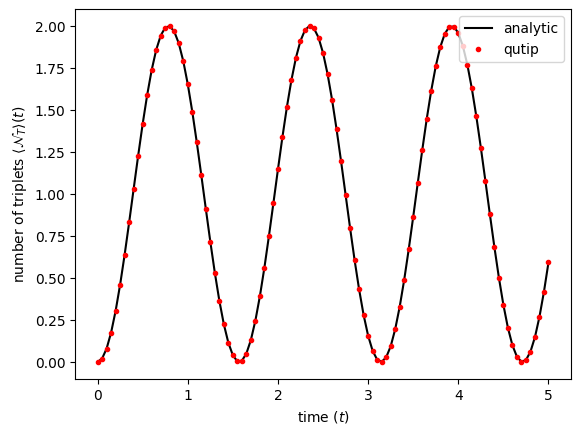

In [13]:
# function to simulate singlet fission using qutip
# returns the number of triplets as a function of time
# tlist: time steps where the solution is evaluated
# gamma: singlet-triplet interaction strength
def Solve(tlist, gamma = 1, progress_bar=True):

    # number of sites
    N = 4

    # singlet energy
    eS = 1.0 

    # singlet transport couplings
    Js = -0.1

    # triplet energy
    eT = eS/2-abs(Js)

    # energies of the states S0,S1,T1
    ens = np.array([0,eS,eT])

    # local dimension
    dim = len(ens)

    # local identity
    id = qeye(dim)

    # local basis
    ground = basis(dim,0)
    triplet = basis(dim,2)
    singlet = basis(dim,1)

    # ---- Construct the local Hamiltonian ----

    # local Hamiltonian term
    h = Qobj(np.diag(ens))

    # local (energy) Hamiltonian (of both singlet and triplet)
    H0 = sum([tensor([id*(i!=k)+h*(i==k) for i in range(N)]) for k in range(N)]) 

    # ---- Construct the transport terms ----

    # excitation creation and annihilation operators 

    s = singlet*ground.dag() # creates singlet S1
    t = triplet*ground.dag() # creates triplet T1

    # indices for interactions (with periodic boundaries)
    pairs = [(np.mod(i,N),np.mod(i+1,N)) for i in range(N)]

    # singlet transport Hamiltonian
    Hs = 0*H0
    for i,j in pairs:
        temp = [id for k in range(N)]
        temp[i] = s
        temp[j] = s.dag()
        Hs += Js * ( tensor(temp) + tensor(temp).dag())

    # singlet-triplet interaction Hamiltonian
    Hint = 0*H0
    for i,j in pairs:
        temp = [id for k in range(N)]
        temp[i] = t*s.dag()
        temp[j] = t
        Hint += gamma * ( tensor(temp) + tensor(temp).dag())
        temp = [id for k in range(N)]
        temp[i] = s*t.dag()
        temp[j] = t.dag()
        Hint += gamma * ( tensor(temp) + tensor(temp).dag())    

    # Full Hamiltonian
    H = H0 + Hs + Hint

    # number of triplets operator
    nT = sum([tensor([id*(i!=k)+t*t.dag()*(i==k) for i in range(N)]) for k in range(N)])

    # initial state
    psi0 = sum([tensor(*[(i==k)*singlet+(i!=k)*ground for i in range(N)]) for k in range(N)]).unit()

    # ----- evolution ----

    # operator to measure 
    e_ops = [nT] 

    # propagate
    results = sesolve(H,psi0,tlist,e_ops=e_ops, progress_bar=progress_bar)

    # data
    NTs = results.expect[0]

    # return number of triplets
    return NTs

# times
dt = 0.05
tt = 100
tlist = np.array([dt*k for k in range(tt+1)])

# qutip solution
NTs = Solve(tlist)

# analytic solution
analytic = lambda t, gamma=1: np.cos(4*gamma*t+np.pi)+1

# Plot
fig, ax = plt.subplots()
ax.plot(tlist, analytic(tlist),'k-', label = 'analytic');
ax.plot(tlist, NTs,'r.', label = 'qutip');
ax.set_ylabel(r'number of triplets $\langle\mathcal{N}_T\rangle(t)$')
ax.set_xlabel(r'time ($t$)')
ax.legend();